In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
print(tf.__version__)
import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

2.9.2


In [19]:
!wget https://huggingface.co/datasets/wider_face/resolve/main/data/WIDER_train.zip

--2023-01-16 08:26:08--  https://huggingface.co/datasets/wider_face/resolve/main/data/WIDER_train.zip
Resolving huggingface.co (huggingface.co)... 3.231.67.228, 54.235.118.239, 2600:1f18:147f:e800:671:b733:ecf3:a585, ...
Connecting to huggingface.co (huggingface.co)|3.231.67.228|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/datasets/wider_face/e23b76129c825cafae8be944f65310b2e1ba1c76885afe732f179c41e5ed6d59?response-content-disposition=attachment%3B%20filename%3D%22WIDER_train.zip%22&Expires=1674115742&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL2RhdGFzZXRzL3dpZGVyX2ZhY2UvZTIzYjc2MTI5YzgyNWNhZmFlOGJlOTQ0ZjY1MzEwYjJlMWJhMWM3Njg4NWFmZTczMmYxNzljNDFlNWVkNmQ1OT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPWF0dGFjaG1lbnQlM0IlMjBmaWxlbmFtZSUzRCUyMldJREVSX3RyYWluLnppcCUyMiIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY3NDExNTc0Mn19fV19&Signature=e9-qFdiOFSo95~DsldYkUj0hJq9bkzm78c

In [20]:
# extract dataset
! unzip WIDER_train.zip

Streaming output truncated to the last 5000 lines.
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_552.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_554.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_567.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_570.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_576.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_591.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_595.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_598.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_6.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_61.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_613.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_617.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_626.jpg  
  i

In [28]:
#capture paths to images
face_images = glob.glob('WIDER_train/*/**/*.jpg')

In [29]:
all_images = []

for i in tqdm(face_images):
  img = tf.keras.utils.load_img(i, target_size=(70,70,3))
  img = tf.keras.utils.img_to_array(img)
  img = img/255.
  all_images.append(img)

100%|██████████| 12880/12880 [02:37<00:00, 81.80it/s]


In [30]:
all_images = np.array(all_images)

# split data into train and validation data
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)

In [31]:
# function to reduce image resolution while keeping the image size constant

def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [32]:
# get low resolution images for the training set
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [36]:
Input_img = Input(shape=(70, 70, 3))  

# Change activation to the string 'relu' for the earlier code
activation = LeakyReLU()
#encoding architecture
x1 = Conv2D(256, (3, 3), activation=activation, padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation=activation, padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation=activation, padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation=activation, padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation=activation, padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation=activation, padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse',metrics='accuracy')


In [37]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 70, 70, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 70, 70, 256)       7168      
                                                                 
 conv2d_8 (Conv2D)           (None, 70, 70, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 35, 35, 64)        73792     
                                                                 
 conv2d_10 (Conv2D)          (None, 35, 35, 64)        36928     
                                                           

In [38]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')

a_e = autoencoder.fit(train_x_px, train_x,
            epochs=50,
            batch_size=128,
            shuffle=True,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper])

Epoch 1/50
91/91 [==============================] - 66s 554ms/step - loss: 0.0427 - accuracy: 0.5970 - val_loss: 0.0169 - val_accuracy: 0.7250
Epoch 2/50
91/91 [==============================] - 46s 502ms/step - loss: 0.0149 - accuracy: 0.7627 - val_loss: 0.0140 - val_accuracy: 0.7683
Epoch 3/50
91/91 [==============================] - 47s 513ms/step - loss: 0.0140 - accuracy: 0.7724 - val_loss: 0.0134 - val_accuracy: 0.7796
Epoch 4/50
91/91 [==============================] - 47s 518ms/step - loss: 0.0134 - accuracy: 0.7846 - val_loss: 0.0132 - val_accuracy: 0.8032
Epoch 5/50
91/91 [==============================] - 47s 516ms/step - loss: 0.0131 - accuracy: 0.7868 - val_loss: 0.0131 - val_accuracy: 0.7909
Epoch 6/50
91/91 [==============================] - 47s 514ms/step - loss: 0.0130 - accuracy: 0.7877 - val_loss: 0.0131 - val_accuracy: 0.8118
Epoch 7/50
91/91 [==============================] - 47s 516ms/step - loss: 0.0129 - accuracy: 0.7872 - val_loss: 0.0131 - val_accuracy: 0.8145

In [39]:
predictions = autoencoder.predict(val_x_px)

41/41 [==============================] - 3s 44ms/step


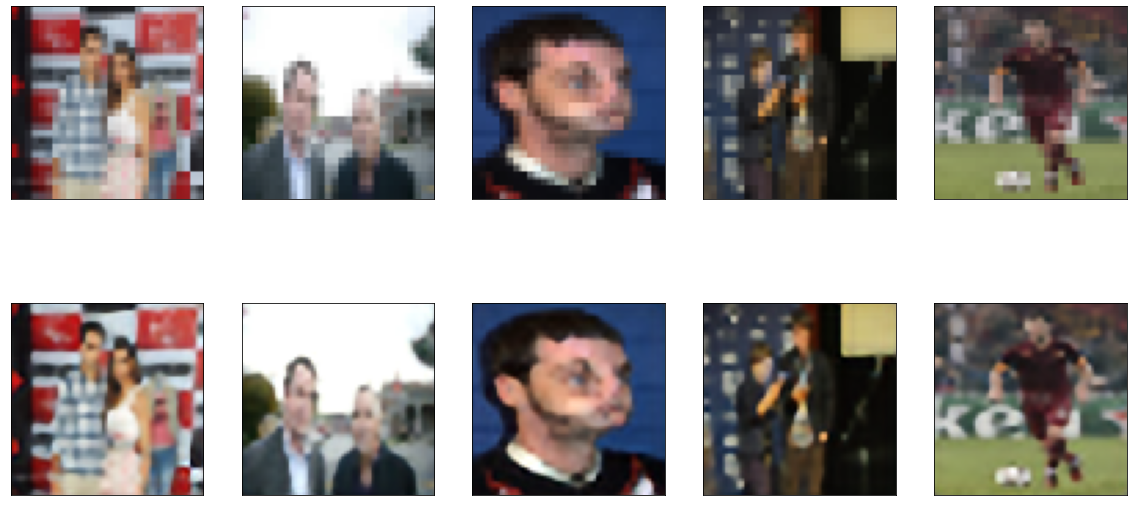

In [40]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()